# GET SPECTRUM

In [1]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import h5py

# Define the data folder - must include .h5 cas and dat files.
#data_folder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"
#data_folder = r"E:\TR_1.0\\"
#data_folder = r"E:\L5\\"
data_folder = "/Volumes/ThermalAmp/TR1-4/"

#from cmcrameri import cm

Trace 2 points to get their spectrum 

In [2]:
def query_point(node_x, node_y, data_file, z1, z2, z3, query_x, query_y):
    """Given a set of cell coordinates node_x, node_y, and a list of requested coordinates query_x, query_y,
    obtain the corresponding z values from the entire z array.
    """
    # Convert lists to numpy arrays if they are not already
    query_x = np.array(query_x)
    query_y = np.array(query_y)

    with h5py.File(data_file, "r") as f:
        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

    
    # Initialize lists to store results
    results = []
    
    # Tolerances - found with trial and error. 
    tolerance = 1e-4
    rtol = 1e-2
    
    for x, y in zip(query_x, query_y):
        queried_indices = np.where(
            np.isclose(node_x, x, atol=tolerance, rtol=rtol) &
            np.isclose(node_y, y, atol=tolerance, rtol=rtol)
        )
        
        # This will likely return multiple values - this is the result of the 
        # first combination of tolerances that returns nonzero close values.
        # It is assumed that they are close enough in value so that we 
        # can take the average of the values corresponding to the found indices
        close_x = np.nanmean(node_x[queried_indices])
        close_y = np.nanmean(node_y[queried_indices])
        close_z1 = np.nanmean(z1[queried_indices])
        close_z2 = np.nanmean(z2[queried_indices])
        close_z3 = np.nanmean(z3 [queried_indices])
        
        #results.append((queried_indices, close_x, close_y, close_z1, close_z2, close_z3, timestep, flowtime))
        results.append((close_z1, close_z2, close_z3, timestep, flowtime))
    
    return results

def get_z_for_datafile(data_file):
    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]
    return U, V, T

def get_query_point_from_datafile(node_x, node_y, data_file, query_x, query_y):
    

    U, V, T = get_z_for_datafile(data_file)

    results = query_point(node_x, node_y, data_file, U, V, T, query_x, query_y)

    #queried_indices, close_x, close_y, close_u = query_point(node_x, node_y, U, query_x, query_y)
    #queried_indices, close_x, close_y, close_v = query_point(node_x, node_y, V, query_x, query_y)

    return results

    
def get_nodes_from_casefile(data_folder):

    # Find .cas.post files
    case_files = [f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
    
    if case_files:
        fname = os.path.join(data_folder, case_files[0])
        
        # Read the mesh data from the HDF5 file
        with h5py.File(fname, 'r') as f:
            vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
        
        # Extract NodeX and NodeY
        node_x = vertex_list[0]
        node_y = vertex_list[1]
    
        return node_x, node_y

In [3]:
case_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
case_files = [f for f in case_files if "/._" not in f]

fname = os.path.join(data_folder, case_files[0])

# Read the mesh data from the HDF5 file
with h5py.File(fname, 'r') as f:
    vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])

# Extract NodeX and NodeY
node_x = vertex_list[0]
node_y = vertex_list[1]


In [4]:
# Find *dat.post files
data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]
data_files = [f for f in data_files if "/._" not in f]

def get_time(data_file):
    return float(data_file.split(".")[0].split("-")[-1])  #My directories
    #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
    #return float(data_file.split(".")[1].split("-")[-1])

data_files = sorted(data_files, key=get_time)

query_x = [0.1, 0.005]
query_y = [-0.01, 0.01]

# Test for 1 data file
get_query_point_from_datafile(node_x, node_y, data_files[-1], query_x, query_y)


[(np.float64(0.0067675823595234495),
  np.float64(-0.000782805002256741),
  np.float64(304.0568491658036),
  32000.0,
  1600.0),
 (np.float64(-0.006332605801286498),
  np.float64(0.015245085203085665),
  np.float64(301.3554779473212),
  32000.0,
  1600.0)]

In [5]:
fnames = [
'/Volumes/ThermalAmp/Tr1.9/',
'/Volumes/ThermalAmp/Tr3.5/',
'/Volumes/ThermalAmp/Tr0.8/',
'/Volumes/ThermalAmp/Tr0.4/',
'/Volumes/ThermalAmp/Tr1-NoCyl/',
'/Volumes/ThermalAmp/Tr1/',
'/Volumes/ThermalAmp/TR1-6/',
'/Volumes/ThermalAmp/Tr1.8/'
]

cases = [#1.8, 
         #1.4, 
    1.9, 3.5, 0.8, 0.4, 'NC', 1.0, 1.6, 1.8]

In [ ]:
from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning

use_parallel = True
for i, Tr in enumerate(cases):

    # Find *dat.post files
    data_files = [fnames[i]+f for f in os.listdir(fnames[i]) if f.endswith('.dat.post')]
    data_files = [f for f in data_files if "/._" not in f]
    
    def get_time(data_file):
        try:
            return float(data_file.split(".")[0].split("-")[-1])  #My directories
            #return float(data_file.split(".")[1].split("-"))  #works with the main KC directory + Grace's 
        except:
            return float(data_file.split(".")[1].split("-")[-1])
    
    data_files = sorted(data_files, key=get_time)
    
    query_x = [0.1, 0.005]
    query_y = [-0.01, 0.01]

    if '30000' in data_files[-1001]:
        dats = data_files[3999:-1001]
    else:
        dats = data_files[0:10000]

    if use_parallel:
        print(data_files[0])
        # Use LokyBackend to protect the h5py routine
        timeseries_results = Parallel(n_jobs=-1, backend='threading', verbose=1) \
        (delayed(get_query_point_from_datafile) \
         (node_x, node_y, data_file, query_x, query_y
         ) for data_file in dats)
        timeseries_results_array = np.array(timeseries_results, dtype=object)
    else:
        for j, data_file in enumerate(dats):
            timeseries_results = get_query_point_from_datafile(node_x, node_y, data_file, query_x, query_y)
            if j in np.arange(0,10001,100):
                print("Done {}".format(data_file))
    #timeseries_results_array = np.array(timeseries_results, dtype=object)

    dat_out = np.column_stack(
        (
            timeseries_results_array[:,:,0], #plumeU
            timeseries_results_array[:,:,1], #plumeV
            timeseries_results_array[:,:,2], #plumeT
            timeseries_results_array[:,:,3][:,0], #timesteps
            timeseries_results_array[:,:,4][:,0], #flowtimes
        )
    )
    datt = pd.DataFrame(dat_out, columns=["plumeU", "vortU", "plumeV", "vortV", "plumeT", "vortT", "plumetstep", "flowt"])
    datt.to_csv("/Volumes/ThermalAmp/DataSeries/Tr{}.csv".format(Tr))

    del timeseries_results_array, dat_out, datt

env: PYTHONWARNINGS=ignore::UserWarning
/Volumes/ThermalAmp/Tr1.9/M4-10002.dat.post


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 10000 out of

/Volumes/ThermalAmp/Tr3.5/M4-10002.dat.post


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 6030 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 7180 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 8430 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 9780 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 10000 out of

/Volumes/ThermalAmp/Tr0.8/M4-10002.dat.post


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 3180 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 4030 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 4980 tasks      | elapsed: 12.3min


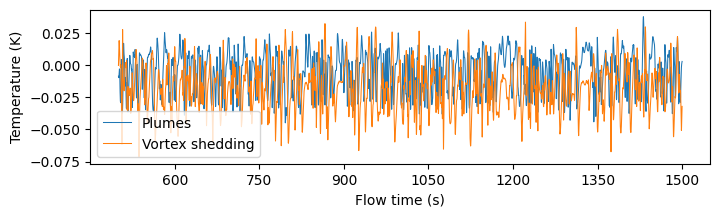

In [10]:
from matplotlib.ticker import MaxNLocator

pdf = pd.read_csv("/Volumes/ThermalAmp/DataSeries/Tr{}.csv".format(1.8))


fig, ax = plt.subplots(figsize=(8,2))

ax.plot(pdf['flowt'].to_numpy(), pdf['plumeT'].to_numpy(), linewidth=0.75, label="Plumes")
ax.plot(pdf['flowt'].to_numpy(), pdf['vortT'].to_numpy(), linewidth=0.75, label="Vortex shedding")
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)) 

ax.set_xlabel("Flow time (s)")
ax.set_ylabel("Temperature (K)")

ax.legend()


In [9]:
def get_spectrum(signal):
    mean_deviated_signal = signal - np.mean(signal)

    SignalLength = len(signal)

    StartTime, EndTime = 0, 600
    TimeVector = np.linspace(StartTime, EndTime, SignalLength)

    DeltaTime = 0.5
    SamplingFrequency = 1 / DeltaTime

    # NUMBER OF FFT POINTS
    nFFT = 2 ** np.ceil(np.log2(SignalLength*4)).astype(int)

    Frequency = SamplingFrequency * np.arange(nFFT // 2 + 1) / nFFT

    # CALCULATE FAST-FOURIER-TRANSFORM AND POWER SPECTRAL DENSITY
    FFTofX = np.fft.fft(signal-np.mean(signal), nFFT)
    PowerSpectralDensity = np.abs(FFTofX[0:nFFT // 2 + 1] / nFFT) ** 2
    
    return Frequency, PowerSpectralDensity


In [12]:
Frequency, PowerSpectralDensity = get_spectrum(pdf['vortT'].to_numpy())
pFrequency, pPowerSpectralDensity = get_spectrum(pdf['plumeT'].to_numpy())

Text(0, 0.5, 'Energy Density $(m/s)^2/Hz$ \n(axis scaled to log$_{10}$)')

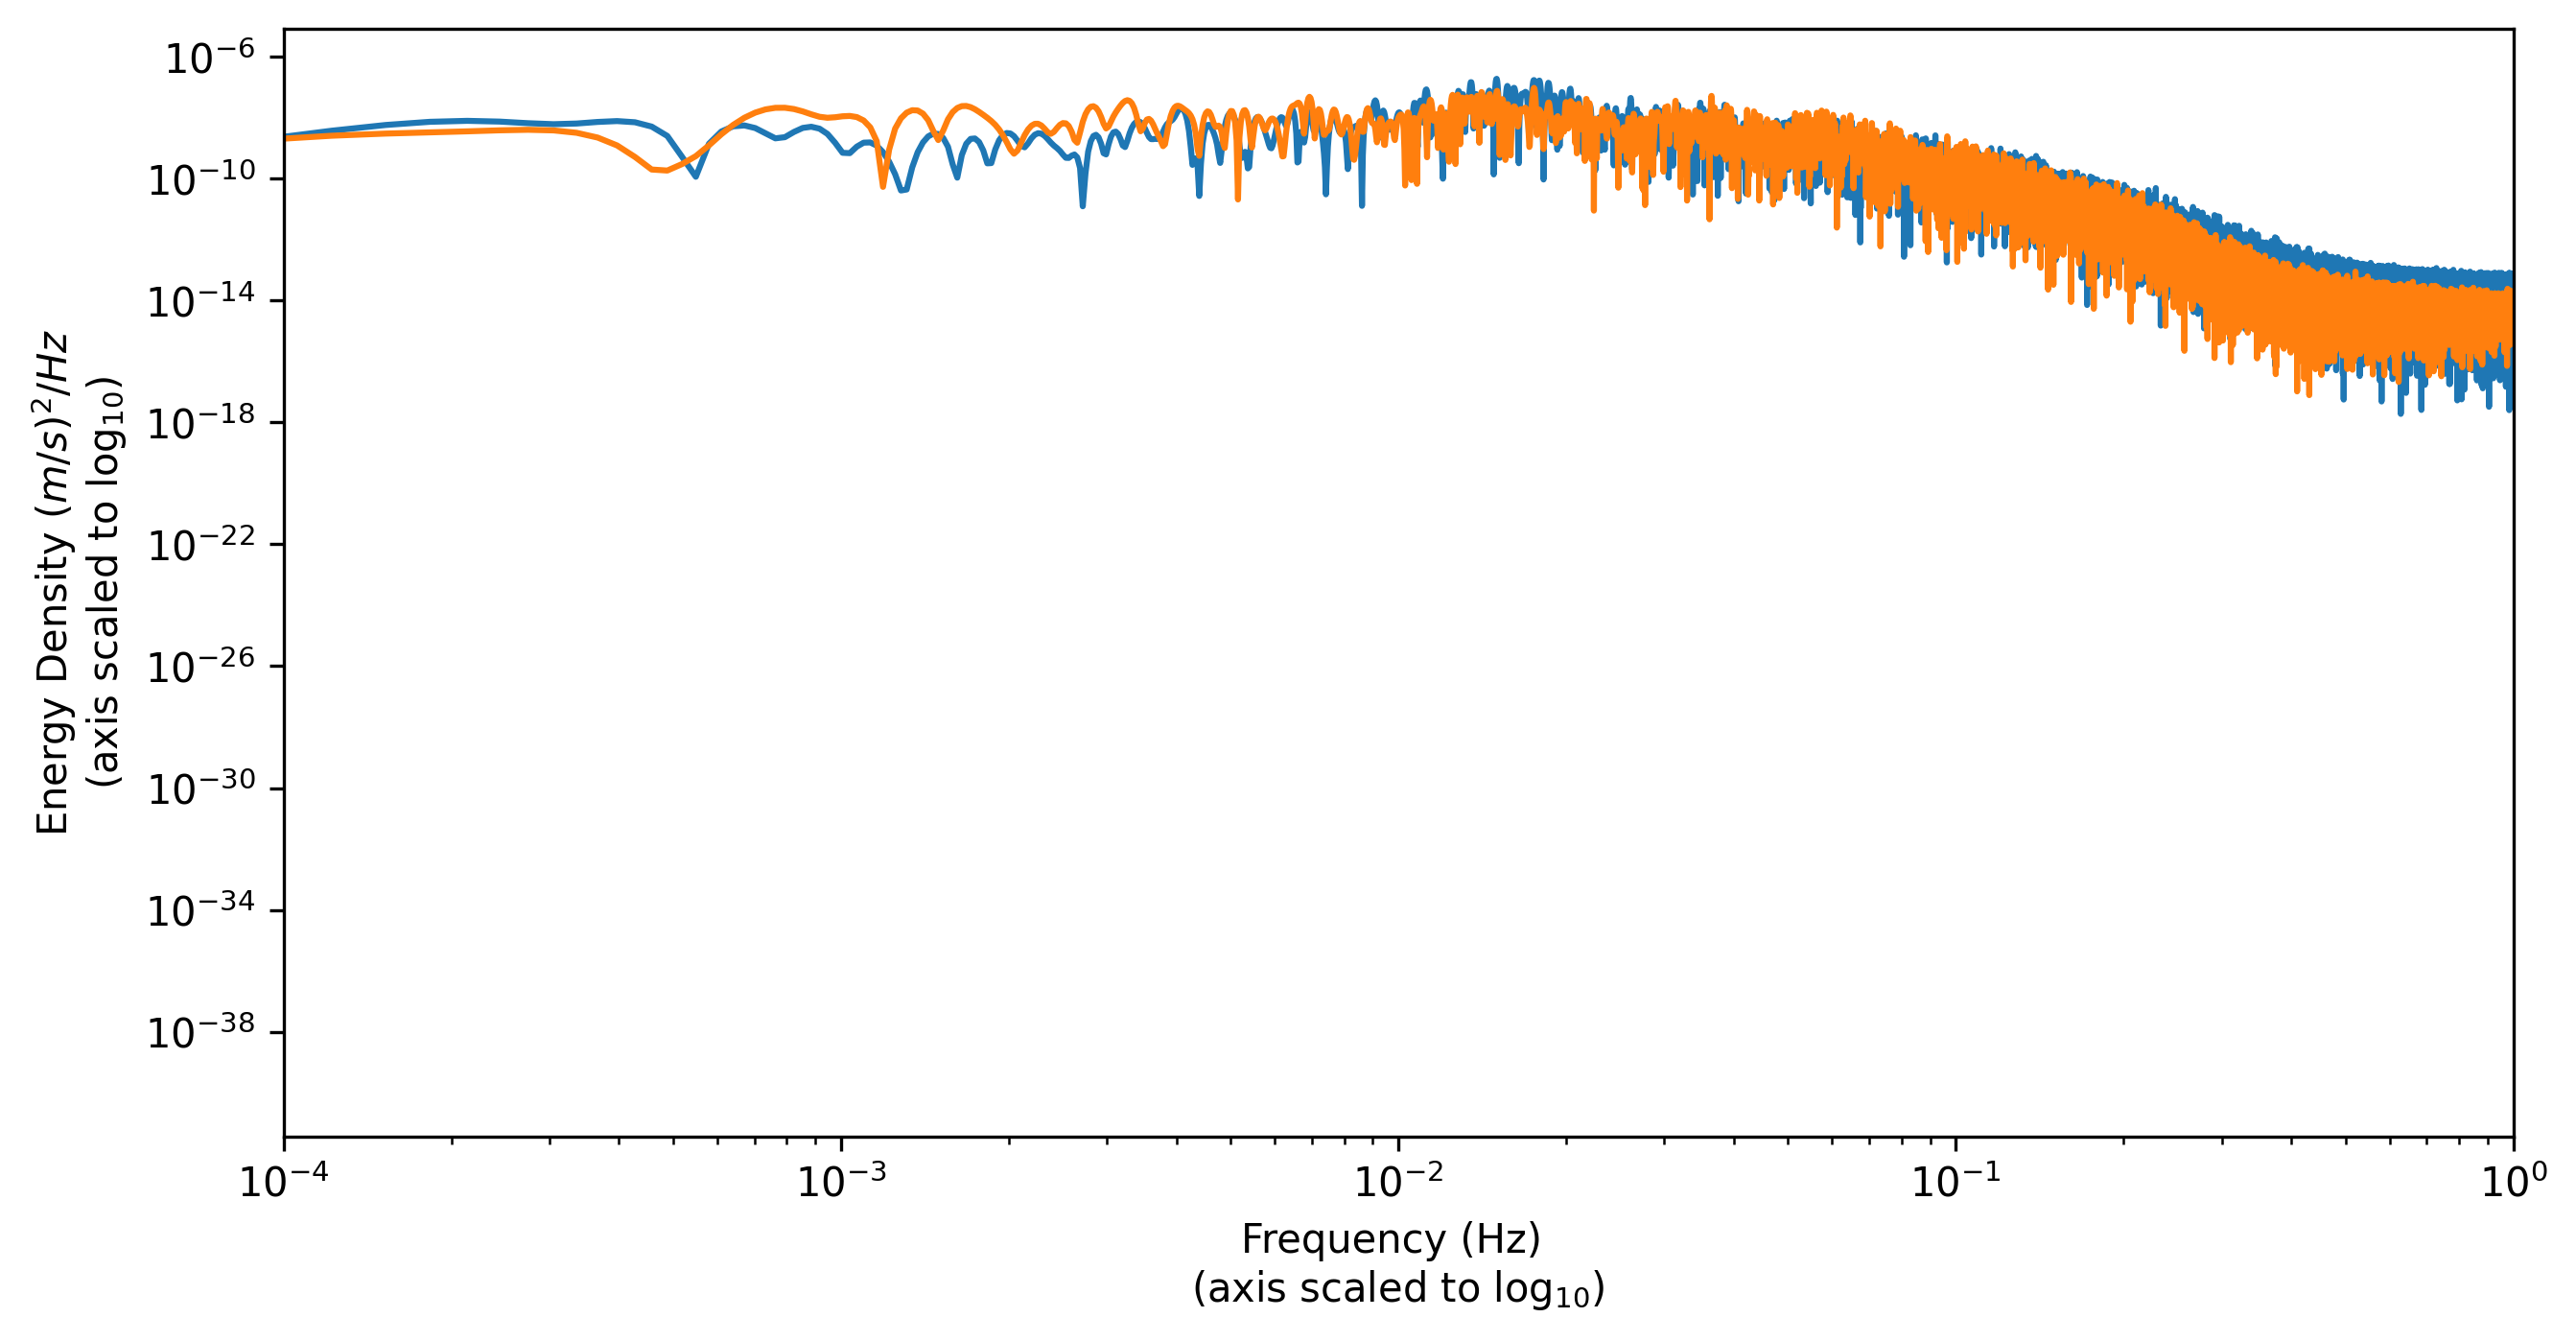

In [15]:

# PLOT THESE
fig, ax = plt.subplots(1, 1, figsize=[10, 5], dpi=300)
plt.plot(Frequency, PowerSpectralDensity, label="Vortex")
plt.plot(pFrequency, pPowerSpectralDensity, label="Plume")
plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-10, 1e1])
plt.xlim([1e-4, 1])

# Kolmogorov's -5/3 law
#plt.plot([1e-2, 1], np.array([1e-2,1])**(-5/3)/100000, color='r', label="Kolmogorov's -5/3 law")
#ax.grid(alpha=0.3)

ax.set_xlabel("Frequency (Hz) \n(axis scaled to log$_{10}$)")
ax.set_ylabel("Energy Density $(m/s)^2/Hz$ \n(axis scaled to log$_{10}$)")